# Exploring the control channels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, transpile, IBMQ
from qiskit import schedule as build_schedule
from qiskit.circuit import Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_jakarta')

In [3]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt

In [4]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
control_qubit = 1
target_qubit = 0
# We will define memory slot channel 0.
control_mem_slot = 1
target_mem_slot = 0

In [5]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [6]:
# Rabi experiment parameters
num_rabi_points = 10

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0.
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [50]:
center_frequency_Hz = backend_defaults.qubit_freq_est[target_qubit]

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
num_frequencies = frequencies_GHz.shape[0]

In [8]:
# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.075 * us                            # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

freq = Parameter('freq')

## Direct drive of target qubit with a Gaussian

In [9]:
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(target_qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    # Define our measurement pulse
    pulse.measure(qubits=[target_qubit, control_qubit], registers=[pulse.MemorySlot(target_mem_slot), pulse.MemorySlot(control_mem_slot)])
        
# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
direct_drive_schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

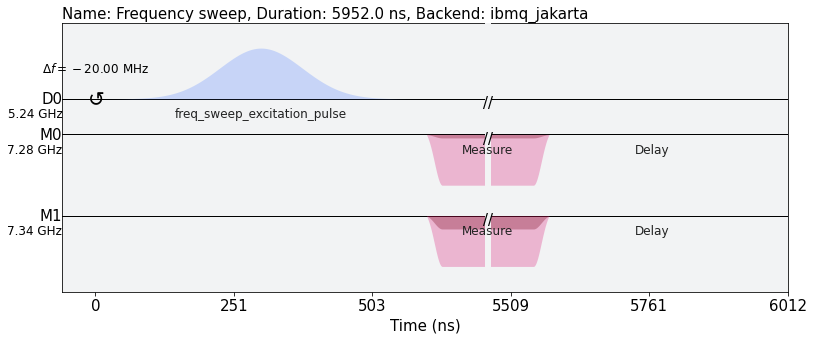

In [11]:
direct_drive_schedules[0].draw(backend=backend)

## Driving the control qubit with the target frequency (GaussianSquare)

In [10]:
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.control_channels(control_qubit, target_qubit)[0]
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.GaussianSquare(duration=704, amp=0.9, sigma=64, width=448, name='CR90p_d1_u0'), drive_chan)
    # Define our measurement pulse
    pulse.measure(qubits=[target_qubit, control_qubit], registers=[pulse.MemorySlot(target_mem_slot), pulse.MemorySlot(control_mem_slot)])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
controlled_drive_schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

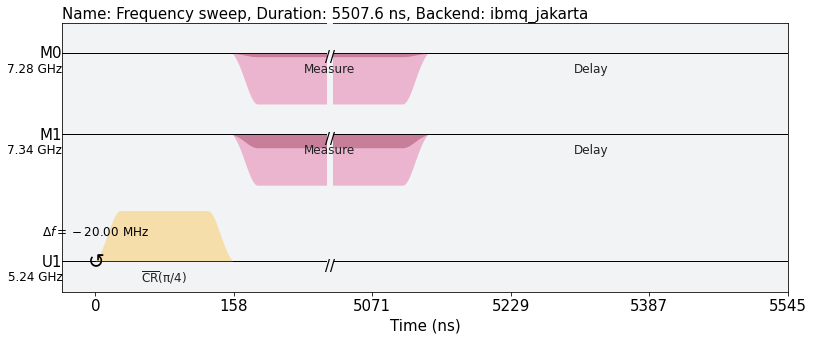

In [12]:
controlled_drive_schedules[0].draw(backend=backend)

In [13]:
def submit_schedules(schedules, shots=1024, monitor=True):
    job = backend.run(schedules,
                      meas_level=1, 
                      meas_return='avg', 
                      shots=shots)

    if monitor:
        job_monitor(job)
        
    return job.result(timeout=120)

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [51]:
def plot_result(result, slot, x=None, indices=None, part=np.real, color='black', xlim=None, xlabel='', ylabel=''):
    if indices is None:
        if x is not None:
            indices = range(x.shape[0])
        else:
            indices = range(len(result.results))
        
    y = np.array([part(result.get_memory(im)[slot]) for im in indices])

    if x is None:
        x = np.arange(y.shape[0])
        
    plt.scatter(x, y, color=color)
    if xlim is not None:
        plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()    

In [15]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

## Target signal from direct drive experiment

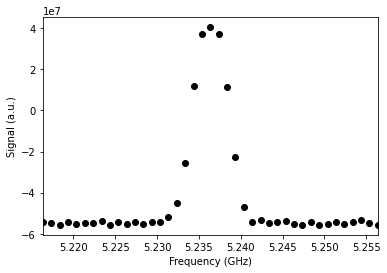

In [48]:
plot_result(frequency_sweep_results, target_mem_slot, x=frequencies_GHz, xlim=[min(frequencies_GHz), max(frequencies_GHz)], xlabel='Frequency (GHz)', ylabel='Signal (a.u.)')

## Control signal from direct drive experiment

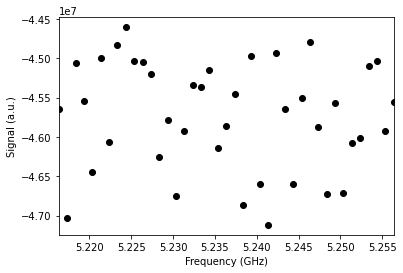

In [49]:
plot_result(frequency_sweep_results, control_mem_slot, x=frequencies_GHz, xlim=[min(frequencies_GHz), max(frequencies_GHz)], xlabel='Frequency (GHz)', ylabel='Signal (a.u.)')

## Target signal from controlled drive experiment

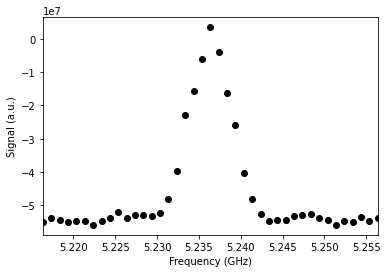

In [52]:
plot_result(frequency_sweep_results, target_mem_slot, x=frequencies_GHz, indices=list(range(num_frequencies, 2 * num_frequencies)), xlim=[min(frequencies_GHz), max(frequencies_GHz)], xlabel='Frequency (GHz)', ylabel='Signal (a.u.)')

## Control signal from controlled drive experiment

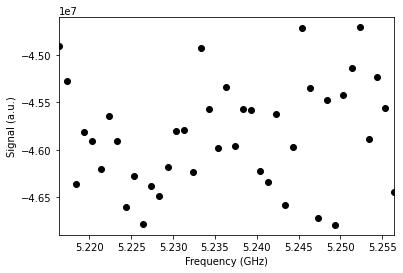

In [53]:
plot_result(frequency_sweep_results, control_mem_slot, x=frequencies_GHz, indices=list(range(num_frequencies, 2 * num_frequencies)), xlim=[min(frequencies_GHz), max(frequencies_GHz)], xlabel='Frequency (GHz)', ylabel='Signal (a.u.)')